# Constructing CNNs with Keras

In this lab, we will look at constructing convolutional networks with Keras. Keras drastically simplifies the process of constructing a network by using predefined network models and layers. 

After installing Keras via `pip install keras` restart your kernel. We will start by building a multilayer perceptron, and then move on to CNNs. Our first data set will be our old friend the MNIST dataset. Lets build a perceptron with one deep layer:

<img width = 500 src = "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png">

We will use this to classify the MNIST dataset. First, we load in MNIST, normalize the X pixel intensities to be between 0 and 1 (this works better with our activation functions) and then encode the labels $Y$ as one-hot encoded categorical variables. We use the `keras.utils` class to do the one-hot encoding, but you could use `pandas.get_dummies` as well.

This tutorial follows closely the excellent tutorials https://nextjournal.com/gkoehler/digit-recognition-with-keras and https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-mnist-mlp.ipynb#scrollTo=-fGvYAbhVADs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from keras.utils import np_utils

## MNIST:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

NUM_LABELS = 10

## Normalize training data to be between 0 and 1, we have to typecast it as a float to do so.
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_test /= 255

X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, NUM_LABELS)
Y_test = np_utils.to_categorical(y_test, NUM_LABELS)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('x_train:', x_train.shape)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)

Recall that to build a sequential model in Keras we import the `sequential` class from `keras.model` and then the types of layers we will use from `keras.labels`. In this case we will be using __dense__ layer and __activation__ layers. 

We then define a new model with `model = Sequential()`. We add layers in sequence with `model.add(layer)` and Keras takes care of the connects for us:


<div class="alert alert-block alert-info">
__Dense__ implements the operation: __output = activation(dot(input, kernel) + bias)__ where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

[Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
</div>

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(256, input_shape=(784,),activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Activation('softmax'))

That's it, we've constructed out model. To compile it we use `model.compile`. We will use the Adam optimizer, which automatically sets a different learning schedule for each weight. For more information about Adam, see [Jason Brownlee's excelent post](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) or [the original paper of Kingma and Ba](https://arxiv.org/abs/1412.6980). 

To train the model, use

`model.fit(X_train, Y_train,
          batch_size=, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))`

* `X_train` is the whole set of training data.
* `Y_train` is the whole set of label data.
* `batch_size` is size of each training minibatch. Remember that 1 is __stochastic gradient decent__ while 60000 (the size of the whole data set) would be __gradient decent__. 
* `verbose` sets how much information to output during fitting. 0 = silent, 1 = progress bar, 2 = one line per epoch.
* `validation_data=()` specifies data to validate on after each training epoch. 

We will save the output of the training in a variable called `history` for later viewing. 

https://keras.io/models/model/

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=1,
          validation_data=(X_test, Y_test))

#### Saving weights with Keras

Unlike pure tensorflow, Keras will track the tensorflow session by default, including keeping the model alive in a session for us. To save out the weights, we use `model.save(FILE_NAME)`. The weights can be recovered by using `model.load_weights`. Be warned: you have to build a model with the same architecture first and then load the weights into it. 

In [ ]:
# saving the model
SAVE_DIR = "./"
MODEL_NAME = 'keras_mnist.h5'
model_path = os.path.join(SAVE_DIR, MODEL_NAME)

model.save(model_path)
print('Saved trained model at %s ' % model_path)

#### Visualizing Training

Keras also saves the models training history. History store the training accuracy, the validation accuracy and the training loss and the validation loss. Below, we plot them against the epoch number

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## Convolutions

Before we start constructing a convolution network, lets take a moment to explore convolutions themselves to see what kinds of downstream layers our convolutions are creating. 



(427, 640, 3)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


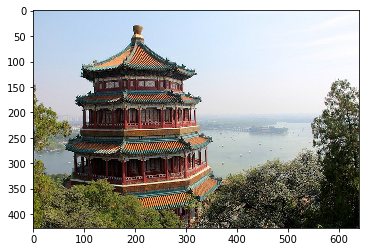

In [5]:
import numpy as np
from sklearn.datasets import load_sample_image
from matplotlib import pyplot as plt
import tensorflow as tf

china = load_sample_image("china.jpg") / 255
print(china.shape)

plt.imshow(china)

The picture we loaded is a color picture, and so has 3 channels (Red, Green, Blue). The shape tells us that the color channels are indexed by the third dimension of the array, and we can plot each channel separately:

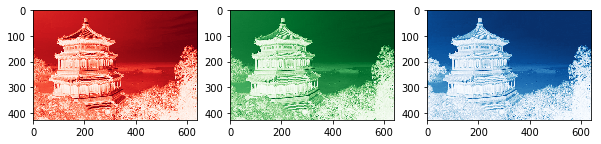

In [11]:
fig, axes = plt.subplots(1,3, figsize=(10, 5))

axes[0].imshow(china[:,:,0], cmap="Reds")
axes[1].imshow(china[:,:,1], cmap="Greens")
axes[2].imshow(china[:,:,2], cmap="Blues")

Given an $n\times m$ matrix $M$, a convolution passes over the image taking the dot product of each $n\times m$ rectangle with the weights of the matrix. 

<img width=600px src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%205/L12Conv1.png">

Lets looks at some examples: The matrix 

$$
M= \left[
\begin{matrix}
0 &-1& 0
\\
0 & 0 & 0
\\
0&1&0
\end{matrix}
\right]
$$

is a horizontal edge detector, since the convolution of $M$ with a $3\times 3$ square of pixels is 0 if the intensity of the top central pixel is the same as the bottom. It only has a large value if the pixel intensity has changed drastically in the vertical direction. Given a convolution matrix like $M$, tensorflow's `tf.nn.conv2d` will compute the convolution for the entire image.

In [58]:
channels = 3    # Since we're using RGB data

M = np.zeros([3,3,channels])

M[0,1,:] = -1     # Set the top ceter element to -1 for all 3 matricies
M[2,1,:] = 1      # Set the bottom ceter element to 1 for all 3 matricies
M[:,:,0]

array([[ 0., -1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.]])

We will now use scipy's ndimage library to convolve the 3d image. There is of course a native tensorflow way to do this (or you could write your own convolve function, it's fairly straight forward) but for just looking, this is the simplest. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


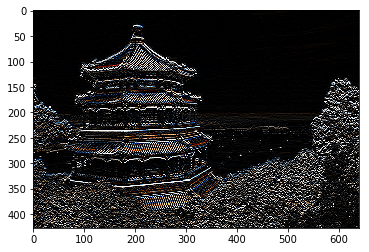

In [59]:
from scipy import ndimage

conv = ndimage.filters.convolve(china, M)
plt.imshow(conv)

Similar to the vertical filter, a horizontal edge detector can be constructed from

$$
H= \left[
\begin{matrix}
0 &0& 0
\\
-1 & 0 & 1
\\
0&0&0
\end{matrix}
\right]
$$

Build out the edge detector below:

Edge detectors can also detect other kinds of features. For example, here is a $5\times 5$ angle detector:


$$
G= \left[
\begin{matrix}
0 &0& 0 & 0 & 0 
\\
0 &-1& -1 & -1 & -1 
\\
0 &-1& 1 & 1 & 1 
\\
0 &-1& 1 & 0 & 0 
\\
0 &-1& 1 & 0 & 0 
\end{matrix}
\right]
$$


[[ 0.  0.  0.  0.  0.]
 [ 0. -1. -1. -1. -1.]
 [ 0. -1.  1.  1.  1.]
 [ 0. -1.  1.  0.  0.]
 [ 0. -1.  1.  0.  0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


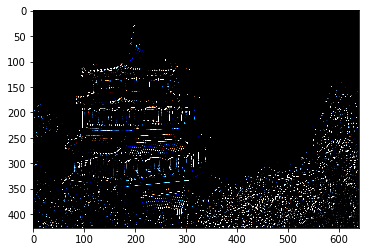

In [64]:
channels = 3    # Since we're using RGB data

G = np.zeros([5,5,channels])

G[1,1:5,:] = -1     
G[1:5,1,:] = -1     
G[2,2:5,:] = 1     
G[2:5,2,:] = 1 
print(G[:,:,0])

conv = ndimage.filters.convolve(china, G)
plt.imshow(conv)

And a Guassian blurring matrix:

$$
G = \left[\begin{matrix}
0.07& 0.13& 0.07\\ 
0.13& 0.20& 0.13\\
0.07& 0.13& 0.07
\end{matrix}\right]
$$

In [84]:
B = np.zeros([3,3,channels])
C = .25*np.array([0.07, 0.13, 0.07,
0.13, 0.20, 0.13,
0.07, 0.13, 0.07]).reshape(3,3)

B[:,:,0] = B[:,:,1] = B[:,:,2] = C

B[:,:,1]

array([[0.0175, 0.0325, 0.0175],
       [0.0325, 0.05  , 0.0325],
       [0.0175, 0.0325, 0.0175]])

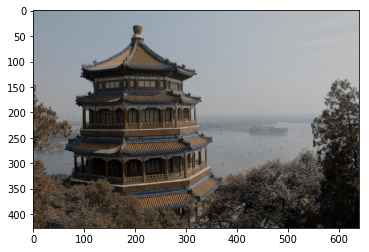

In [85]:
conv = ndimage.filters.convolve(china, B)
plt.imshow(conv)

## Convolutional Neural Networks

Lets try out our perceptron network on something a little more complicated. The fashion MNIST dataset has a very similar structure to MNIST except that instead of simple hand written digits it contains $28\times 28$ images of items of clothing:

<img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png">

Here is a nonlinear 3 dimensional projection of the $28\times 28$ dimensional dataset using TSNE, courtesy of the datasets home repo (https://github.com/zalandoresearch/fashion-mnist)

<img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/embedding.gif">

We load it as below and process it with the same code as before. Take a moment to poke around the dataset before processing it, the labels are

Label|Description|Label|Description
--- | --- |--- | ---
0|T-shirt/top|5|Sandal
1|Trouser|6|Shirt
2|Pullover|7|Sneaker
3|Dress|8|Bag
4|Coat|9|Ankle boot

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
plt.imshow(x_train[0])

Processing the data:

In [ ]:
NUM_LABELS = 10

## Normalize training data to be between 0 and 1, we have to typecast it as a float to do so.
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_test /= 255

X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, NUM_LABELS)
Y_test = np_utils.to_categorical(y_test, NUM_LABELS)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('x_train:', x_train.shape)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)

Now, try running the perceptron network about and note the validation error, you may need to increase the number of epochs to get reasonable results. 

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=(784,),activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=100,
          verbose=1,
          validation_data=(X_test, Y_test))

#### Building a CNN

My error on the MLP never capped 82%, even with 100 epochs. Can we do better with a CNN? Recall that CNN's are comprised of stacks of convolution layers, activation layers, pooling layers and finally a flattening layer:

<table bgcolor="#fafafa"><tr>
    <td>__Convolution Layer__</td><td><img width=400 src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%205/L5ConvLayer.PNG">
    </tr>
    <td>__Pooling Layer__</td><td><img width=300 src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%205/L5PoolingLayer.PNG">
    </tr><tr>
    <td>__Flattening Layer__</td><td><img width=100 src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%205/L5FlatteningLayer.PNG">
    </tr></table>
    
A convolution layer is defined with    
    
    `Conv2D(nb_filters, kernel_size,
                 padding='valid',
                 input_shape=input_shape,
                 activation='relu')`
                 
Where

* `nb_filters` number of convolution filters.
* `kernel_size` size of each filter, say [5,5] for a $5\times 5$ filter.
* `padding` When we convolve, we tend to lower the image size. We can choose to pad the image back to its original size or not. 
* `input_shape` shape of the inputed training data, only required for the first layer. 
* `activation` the activation layer following the convolution layer. 

For a pooling layer we only specify the pool size:

* `MaxPooling2D(pool_size=pool_size)` where `pool_size = [2,2]` down-samples by 2 in each direction. 

After we down-sample enough, we flatten and feed the network into a dense layer to do the fitting. The final architecture looks like the cartoon from class:

<img width= 700 src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%205/L12CNN2.PNG">

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D 

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

## We renormalize the training data since we do not need to flatten it
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_test /= 255

## We have to add an extra dimension to allow for the multiple images we will be creating
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

Y_train = np_utils.to_categorical(y_train, NUM_LABELS)
Y_test = np_utils.to_categorical(y_test, NUM_LABELS)

Now, lets create our model. Our convolution layers will have $3\times 3$ filters followed by downsampling.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (7,7),
                 padding='valid',
                 input_shape=(28, 28,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Lets fit, and plot the results. Each epoch will take 10-100 s depending on your processor. 

In [ ]:
epochs = 5

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_test, Y_test))

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## Understanding the model

There are two things we would like to understand about a CNN: __what is it doing__ and __what is it not doing__? To answer the first question let open up the box a bit and see what the first few convolution kernels look like. 

The `model.layers[]` array gives a list of handlers for the model layers in the order given by summary. Note that you can also name your layers and call them that way. We then use `layer.get_weights()` to return the convolution and bias weights for each of the 32 kernel layers. 

In [ ]:
weights, biases = model.layers[0].get_weights()
print(weights.shape)

plt.imshow(weights[:,:,0,9],cmap="Greys")

#### Exercise:

Display all of the kernels in a grid. In addition, normalize the color scheme so that each image uses the same scheme. 

In [ ]:
f, axes = plt.subplots(4,8, figsize=(10,5))

axes = axes.reshape(-1)
for i in range(32):
    axes[i].imshow(weights[:,:,0,i],cmap="Greys")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

On the otherhand, its important to know what we're getting wrong. Lets construct the confusion matrix to discern which images the network has the hardest time classifying. 

Label|Description|Label|Description
--- | --- |--- | ---
0|T-shirt/top|5|Sandal
1|Trouser|6|Shirt
2|Pullover|7|Sneaker
3|Dress|8|Bag
4|Coat|9|Ankle boot

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_hat = np.argmax(model.predict(X_test),axis=1)
conf_mx = confusion_matrix(y_test, y_hat)

## Remove diagonal for better viewing
row_sum = conf_mx.sum(axis=1, keepdims=True)
nconf_mx = conf_mx/row_sum
np.fill_diagonal(nconf_mx,0)

labels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

sns.heatmap(nconf_mx, xticklabels=labels, yticklabels=labels)

## Transfer Learning: Using Pretrained Models

This section is taken directly from the _Pretrained Models_ section of _Chapter 14_ of Geron. The code is mostly taken from the notebook accompanying Chapter 14. Please use that section as a companion to the code below. 

In this part of the  lab, we want to use the weights of a pretrained model to construct a new classifier. In this case, the pretrained model we will use is Xception model (https://arxiv.org/abs/1610.02357), with weights trained on the Imagenet dataset. We will use a data set of images of flowers from within tensorflow, and modify the output to classify flower types instead of the many label Imagenet categories. 

First, we load the flowers dataset from the Tensorflow datasets library `tensorflow_datasets`. If you do not already have this library, you may need to install it using `pip install tensorflow_datasets` from the anaconda prompt. 

#### Note: This part of the lab requires Tensroflow version 2.0.0. There is a problem with Tensorflow version 2.1.0 on the PC, you may need to downgrade to 2.0.0.

If you try to load the dataset and it dumps a bunch of random errors at you, downgrade to version 2.0.0 using

    pip uninstall tensorflow
    pip install tensorflow==2.0.0
    
   

In [1]:
import tensorflow as tf
import keras
tf.__version__

Using TensorFlow backend.


'2.0.0'

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

class_names = info.features["label"].names
print("Class Names:", class_names)
print(info)

Class Names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



The DatasetInfo dictionary contains a lot of information about the dataset. In this case we see that there are 3670 training images of various shapes and 5 classes. Finally, it tells us that the dataset has two "features", one called __images__ containing the images and one called __labels__, containing the labels. 

The dataset is stored in a `DatasetV1Adapter` object, which is designed to hold datasets in standardized way that only allows certain kinds of manipulations. While it's not easy to access the data directly, the `DatasetV1Adapter` allows us to sample $n$ points from the data using `DatasetV1Adapter.take(n)`, or iterate over the entire dataset as we would iterate over a standard list. 

Lets make a train test split using the `Dataset` functions:

In [3]:
sp = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

(raw_train, raw_validation, raw_test) = tfds.load("tf_flowers", split=sp, as_supervised=True)
raw_train

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

We can sample a few images from the training data and display them with their labels. We use a for loop to iterate over the sample of the training data, saving out the image and the label:

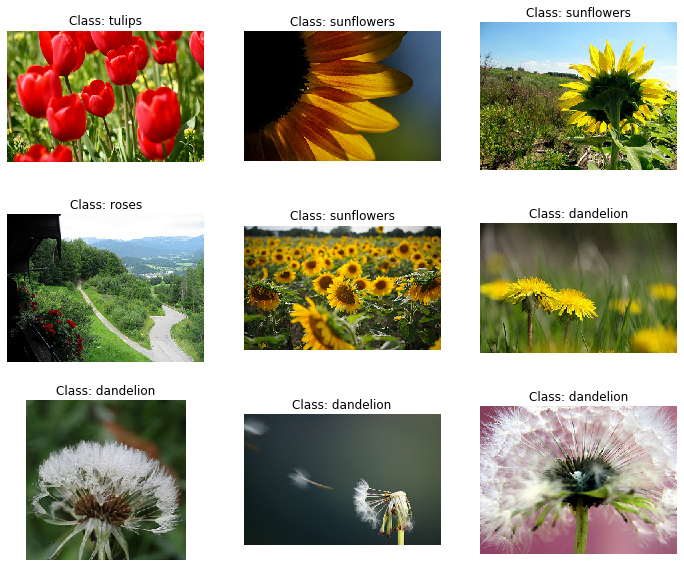

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in raw_train.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

The CNN expects $224\times 224$ dimensional input images, and if you look above you'll notice that not all of the images are the same size. Our solution will be to crop the images down to size using `tf.image.resize`. We then use the `keras.applications.xception.preprocess_input` function to preprocess the pictures. A preprocessing function often accompanies a pretrained network and it used to put the input into the format the network expects. For example, some networks expect greyscale images, some networks expect image scaled between [0,1], other between [-1,1], others use centered images that are otherwise not normalized. 

There are a lot more data augmentation steps we could add to our preprocessing pipeline, including taking random cropings off our image, rotating, flipping or scaling the image. This is often helpful when you have a small training dataset. I will hold off on other preprocessing steps until the end of the lab. 

In [5]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

To apply our preprocessing function to the data we need to use the `DatasetV1Adapter.map(func)` command. This will apply the function `func` to each element of the `DatasetV1Adapter` object. We then shuffle the data, split it into batches for training. Finally, we tell Python to __prefetch__ the data. Prefetching loads the data into memory now and stores it there. Otherwise, Python may try to intelligently allocate the resources by only loading images when they are needed. This will drastically slow down training

In [6]:
batch_size = 32
raw_train = raw_train.shuffle(1000)
raw_train = raw_train.map(preprocess).batch(batch_size).prefetch(1)
raw_validation = raw_validation.map(preprocess).batch(batch_size).prefetch(1)
raw_test = raw_test.map(preprocess).batch(batch_size).prefetch(1)

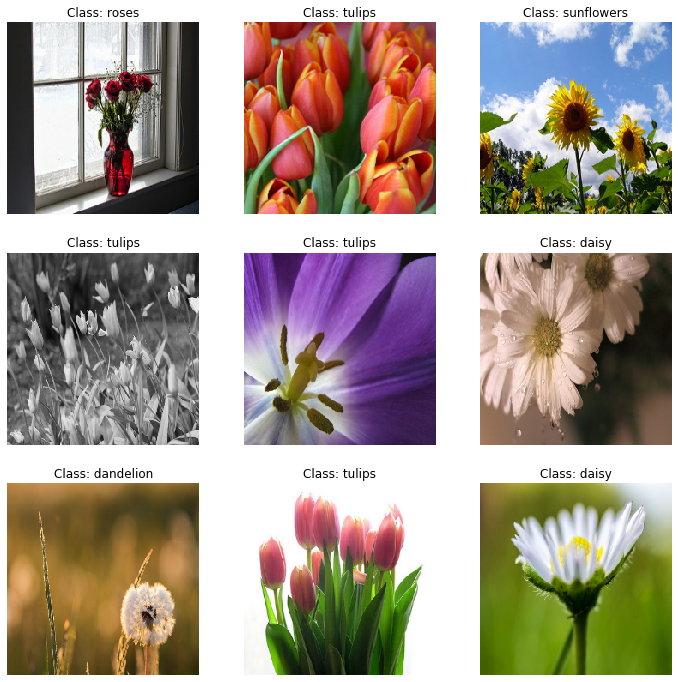

In [7]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in raw_train.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Now we want to load the the Xception model and change it output dimension. We set `include_top=False` to remove the last two layers of the network: the global pooling layer and it's dense connection to the output layer. We will replace them with our own global pooling layer and output to our 5 classes. 

For Keras, since we're not using a sequential network, when we add new layers we just have to tell the network which outputs to connect them to. This is done via

    NewLayer = tf.keras.layers.LAYERTYPE(Parameters)(OldLayer)
    
Using this syntax, we add a __global pooling layer__ and a __dense layer__ with 5 outputs, one for each class. 

Note: The use of `tf.keras` forces keras to use the version compatible with the Tensorflow 2.0.0 backend, otherwise you will have errors. 

In [8]:
raw_train

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [92]:
n_classes = len(class_names)

base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

Finally, at first we don't want to train the all 20,871,725 parameters of the model, so we will freeze all of the layers we borrowed from Xception and only keep the weights of the last dense layer as trainable. 

In [93]:
for layer in base_model.layers:
    layer.trainable = False

Lets train the model. On a CPU it will take around 20 minutes per epoch.

In [98]:
optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(raw_train, epochs=5, validation_data=raw_validation)

Epoch 1/5
92/92 [==============================] - 1195s 13s/step - loss: 0.6828 - accuracy: 0.7742 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
92/92 [==============================] - 1152s 13s/step - loss: 0.3606 - accuracy: 0.8750 - val_loss: 0.6837 - val_accuracy: 0.8447
Epoch 3/5
92/92 [==============================] - 1184s 13s/step - loss: 0.2598 - accuracy: 0.9125 - val_loss: 1.0661 - val_accuracy: 0.7684
Epoch 4/5
92/92 [==============================] - 1230s 13s/step - loss: 0.2229 - accuracy: 0.9213 - val_loss: 0.8065 - val_accuracy: 0.8202
Epoch 5/5
92/92 [==============================] - 1222s 13s/step - loss: 0.1909 - accuracy: 0.9336 - val_loss: 0.9091 - val_accuracy: 0.8011


After 5 epochs our model is doing fairly well. If you would like you can now unfreeze the upper layers and have them train too. This will take a while but you can actually acheave accuray of up to 95%. Not bad for an afternoons work.

# Problem 1:

Construct a CNN to classify the images in the MRI dataset. 

# Problem 2: Pretrained Networks

Using OpenCV, we can also capture images from the computers camera. Open CV is a powerful image processing library from C++ that servers as the benchmark in image processing across industries. To install the python bindings for open CV, open an anaconda prompt (or console on OSX) any use 

Windows:

    conda install -c menpo opencv
    
OSX/*nix:

    conda install --channel https://conda.anaconda.org/menpo opencv3

to install open CV. 

(480, 640, 3)


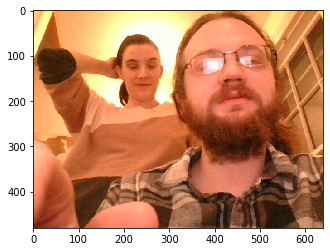

In [5]:
import cv2
video_capture = cv2.VideoCapture(0)
# Check success
if not video_capture.isOpened():
    raise Exception("Could not open video device")
# Read picture. ret === True on success
ret, frame = video_capture.read()
# Close device
video_capture.release()


from matplotlib import pyplot as plt
frameRGB = frame[:,:,::-1] # BGR => RGB
plt.imshow(frameRGB)

print(frame.shape)

Let's pull in our preprocessing functions for the Xception network:

In [6]:
import tensorflow as tf

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

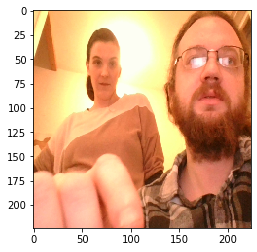

In [7]:
import cv2
video_capture = cv2.VideoCapture(0)
# Check success
if not video_capture.isOpened():
    raise Exception("Could not open video device")
# Read picture. ret === True on success
ret, frame = video_capture.read()
# Close device
video_capture.release()


from matplotlib import pyplot as plt
frameRGB = frame[:,:,::-1] # BGR => RGB
plt.imshow((preprocess(frameRGB,1)[0].numpy() + 1)/2)

Note: `xception.preprocess_input` scales and shifts the image to take pixel values between [-1,1]. For `plt.imshow` to properly display the color information you must add 1 and divide by 2.  

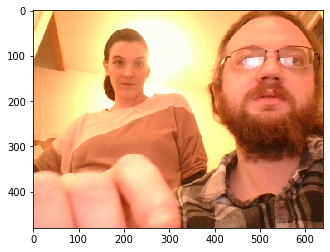

In [8]:
plt.imshow(frameRGB)

You can use the code above to capture 100 pictures of yourself, and split the pictures into labeled sets. For example, you could capture 100 smiling picture and 100 angry pictures. Or 100 pictures in each of 3 different hats. 

In [12]:
import numpy as np

N = 4 # Number of Pictures per Category
C = 3  # Number of categories, for example happy, angry, sad

a_shape = (C*N,) + frameRGB.shape # We want an array the shape of your cameras image, with C*N items. 

x_train = np.zeros(a_shape)
y_train = np.zeros([N*C]).astype('int64')

labels = ["Nate", "Rachel", "Both"]


print(x_train.shape)

(12, 480, 640, 3)


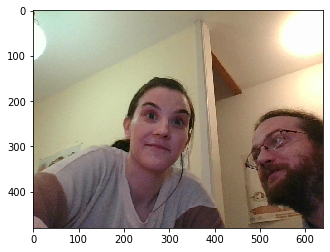

In [15]:

import time
import os
from IPython.display import display, clear_output


video_capture.release()  # Release hold of the camera in case its still active
video_capture = cv2.VideoCapture(0)

# Check success
if not video_capture.isOpened():
    raise Exception("Could not open video device")
# Read picture. ret === True on success

for j in range(C):
    for i in range(N):
        print("Category:", labels[j])
        
        print("Picture",i)
        os.system("printf '\a'") # or '\7'
        time.sleep(2)
        clear_output(wait=True)
        ret, frame = video_capture.read()
        if ret:
            frameRGB = frame[:,:,::-1]
            x_train[N*j+i,:,:,:] = frameRGB
            y_train[N*j+i] = j
            plt.imshow(frame[:,:,::-1])
            plt.show()

        else:
            print("Could not take picture")

        # Close device
video_capture.release()

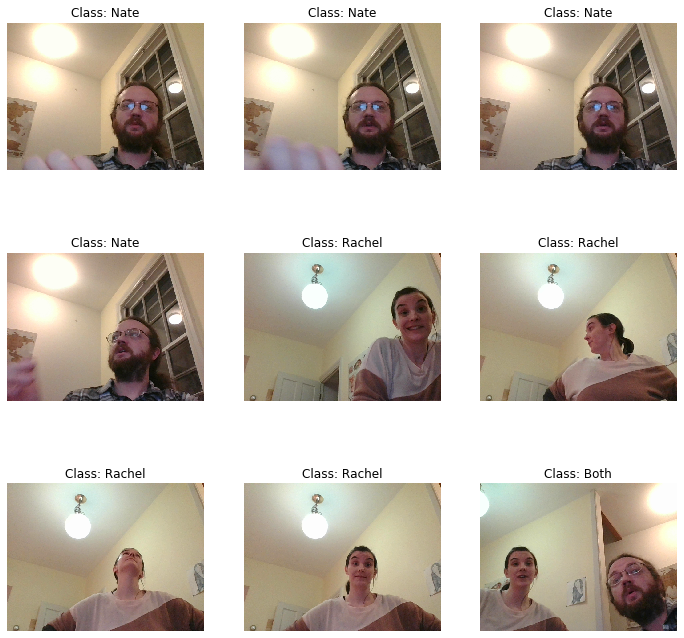

In [16]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i,:,:,:]/255)
    plt.title("Class: {}".format(labels[y_train[i]]))
    plt.axis("off")

We now want to train the network on this data. The Xception model expects a Tensorflow dataset object instead of a set of images and labels. This requires building a Tensorflow dataset. This is not hard once you have the syntax together. The simplest way to generate a dataset from data is using a `from_tensor_slices` call:

* `ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))` - Constructs a dataset with X data `x_train` and label data `y_train`. Data can be quarried using `ds.take`. 

In general, `tf.Dataset` objects enforce some data handling standards, and although they can be a bit of trouble to work with, they also contain useful functions for batching, preprocessing, and shuffling. 

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [17]:
ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ds

<TensorSliceDataset shapes: ((480, 640, 3), ()), types: (tf.float64, tf.int64)>

We now split our data into batches, shuffle it, and preprocess it:

In [18]:
batch_size = 1
ds = ds.shuffle(1)
ds = ds.map(preprocess).batch(batch_size).prefetch(1)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

Finally, we form the train-test split. We will take 2/3 of our data as train and 2/3 as validate. Since in this example we're using 12 images, this means we `take` 9 data points and `skip` the other 3:

In [19]:
ds.train=ds.take(9)
ds.validate=ds.skip(9) 

Now, we load the Xception model:

In [20]:
n_classes = len(labels)

base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Freeze the internal layers

In [21]:
for layer in base_model.layers:
    layer.trainable = False

and train:

In [22]:
optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(ds.train, epochs=5, validation_data=ds.validate)

Epoch 1/5
9/9 [==============================] - 5s 583ms/step - loss: 7.4770 - accuracy: 0.5556 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
9/9 [==============================] - 2s 246ms/step - loss: 35.1518 - accuracy: 0.0000e+00 - val_loss: 23.5158 - val_accuracy: 0.0000e+00
Epoch 3/5
9/9 [==============================] - 2s 273ms/step - loss: 8.6308 - accuracy: 0.2222 - val_loss: 33.5465 - val_accuracy: 0.0000e+00
Epoch 4/5
9/9 [==============================] - 3s 292ms/step - loss: 4.8790 - accuracy: 0.2222 - val_loss: 26.0652 - val_accuracy: 0.0000e+00
Epoch 5/5
9/9 [==============================] - 2s 253ms/step - loss: 1.3618 - accuracy: 0.7778 - val_loss: 19.4364 - val_accuracy: 0.0000e+00


#### Question:

Modify the code above to classify something of your choosing. For example, take pictures of yourself and a friend, in one hat or another, your dog vs your hamster. Your initial dataset should be around 100 images per class. Can you construct an accurate classifier?

#### Question (Alternative):

Kaggle hosts a dataset of movies posters that can be classified by genre. 

https://www.kaggle.com/neha1703/movie-genre-from-its-poster

Repeat the pipeline above to classify the movies posters. This task will involve several steps:

1. Download the data. 
2. Load the labels file, and get the number of unique labels.  
3. Since movies have multiple labels, you should construct a label vector that has a 1 for every genre the movie represents and a 0 otherwise. 
4. Load the images and store them in tf.Dataset. 
5. Construct a new Xception extension to classify the images. You will need to change "sparse_categorical_crossentropy" which takes integer values to keras.losses.CategoricalCrossentropy(from_logits=True). This will instead compute individual probabilities for each label.  